In [4]:
from datetime import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import backtrader as bt
import yfinance as yf


stocks = pd.read_csv('C:/Users/amolk/Desktop/stocks.csv', index_col = "Date")
print(stocks.head(10))

nifty = pd.read_csv('C:/Users/amolk/Desktop/nifty.csv', index_col = "Date")
print(nifty.head(10))

tickerlist = stocks.columns
print(tickerlist)

            ASIANPAINT  AXISBANK  BAJFINANCE     BPCL  BRITANNIA  CIPLA  \
Date                                                                      
30-06-1999      12.428      3.11       2.815  21.4800     84.380  38.39   
01-07-1999      12.382      3.13       2.824  21.0583     83.430  38.15   
02-07-1999      12.988      3.15       2.833  20.7833     84.845  38.94   
05-07-1999      13.942      3.11       2.847  21.0083     86.495  40.02   
06-07-1999      14.416      3.13       2.856  21.6050     86.545  41.43   
07-07-1999      13.772      3.21       2.833  21.7967     86.175  42.18   
08-07-1999      13.474      3.16       2.833  21.4550     85.435  42.73   
09-07-1999      13.814      3.15       2.865  21.2833     85.675  46.15   
12-07-1999      14.346      3.40       2.897  22.6217     86.850  47.84   
13-07-1999      13.792      3.37       2.884  23.8217     86.380  45.92   

            DRREDDY  EICHERMOT   GRASIM   HDFC  ...  RELIANCE    SBIN  \
Date                      

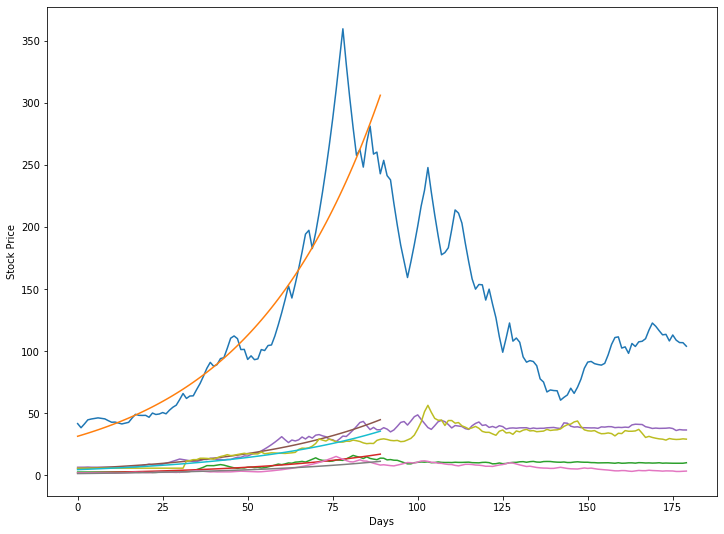

In [5]:
#Define a function which calculates momentum based in the linear regression slope

from scipy.stats import linregress
def momentum(close):
    returns = np.log(close)
    x = np.arange(len(returns))
    slope, intercept, rvalue, pvalue, stderr = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)


#Calculate Momentum for each ticker in the list
momentums = stocks.copy(deep=True)
for ticker in tickerlist:
    momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)

#Initiate plots
plt.figure(figsize=(12, 9))
plt.xlabel('Days')
plt.ylabel('Stock Price')

#Select the top 5 momentum from the dataframe and Plot the graph of the top five momentum stocks
top_five = momentums.max().sort_values(ascending=False).index[:5]
for value in top_five:
    end = momentums[value].index.get_loc(momentums[value].idxmax())
    rets = np.log(stocks[value].iloc[end - 90 : end])
    x = np.arange(len(rets))
    slope, intercept, rvalue, pvalue, stderr = linregress(x, rets)
    plt.plot(np.arange(180), stocks[value][end-90:end+90])
    plt.plot(x, np.e ** (intercept + slope*x))

In [6]:
#Backtesting the strategy in Backtrader

#Define the indicator and Strategy
class Momentum(bt.Indicator):
    lines = ('trend',)
    params = (('period', 90),)
    
    def __init__(self):
        self.addminperiod(self.params.period)
    
    def next(self):
        returns = np.log(self.data.get(size=self.p.period))
        x = np.arange(len(returns))
        slope, intercept, rvalue, pvalue, stderr = linregress(x, returns)
        annualized = (1 + slope) ** 252
        self.lines.trend[0] = annualized * (rvalue ** 2)
        
        
class Strategy(bt.Strategy):
    def __init__(self):
        self.i = 0
        self.inds = {}
        self.spy = self.datas[0]
        self.stocks = self.datas[1:]
        
        self.nifty_sma200 = bt.indicators.SimpleMovingAverage(self.nifty.close,period=200)
        
        for d in self.stocks:
            self.inds[d] = {}
            self.inds[d]["momentum"] = Momentum(d.close, period=90)
            self.inds[d]["sma100"] = bt.indicators.SimpleMovingAverage(d.close, period=100)
            self.inds[d]["atr20"] = bt.indicators.ATR(d, period=20)

    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()
    
    def next(self):
        if self.i % 5 == 0:
            self.rebalance_portfolio()
        if self.i % 10 == 0:
            self.rebalance_positions()
        self.i += 1
    
    def rebalance_portfolio(self):
        # only look at data that we can have indicators for 
        self.rankings = list(filter(lambda d: len(d) > 100, self.stocks))
        self.rankings.sort(key=lambda d: self.inds[d]["momentum"][0])
        num_stocks = len(self.rankings)
        
        # sell stocks based on criteria
        for i, d in enumerate(self.rankings):
            if self.getposition(self.data).size:
                if i > num_stocks * 0.2 or d < self.inds[d]["sma100"]:
                    self.close(d)
        
        if self.spy < self.spy_sma200:
            return
        
        # buy stocks with remaining cash
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(self.data).size:
                size = value * 0.001 / self.inds[d]["atr20"]
                self.buy(d, size=size)
                
        
    def rebalance_positions(self):
        num_stocks = len(self.rankings)
        
        if self.spy < self.spy_sma200:
            return

        # rebalance all stocks
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            size = value * 0.001 / self.inds[d]["atr20"]
            self.order_target_size(d, size)



In [7]:
#Initialize the backtester

cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

# Add the datafeed to the backtester

cerebro.adddata(bt.feeds.PandasData(dataname=nifty, plot=False)) 

cerebro.adddata(bt.feeds.PandasData(dataname=stocks, plot=False))

       

#Add Observer and Analyzer  
        
cerebro.addobserver(bt.observers.Value)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)

cerebro.addanalyzer(bt.analyzers.Returns)

cerebro.addanalyzer(bt.analyzers.DrawDown)


#Add the strategy to the backtester
cerebro.addstrategy(Strategy)


0

In [8]:
#Run Analysis and store result in results

results = cerebro.run()

AttributeError: 'str' object has no attribute 'to_pydatetime'

In [9]:
#Plot the results

cerebro.plot(iplot=False)[0][0]

#Print the performance metrics
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

IndexError: list index out of range